In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import h5py

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  train_dataset = h5py.File('train_catvnoncat.h5','r')
  test_dataset = h5py.File('test_catvnoncat.h5','r')
  
  train_set_X_orig = np.array(train_dataset['train_set_x'][:])
  train_set_Y_orig = np.array(train_dataset['train_set_y'][:])
  test_set_X_orig = np.array(test_dataset['test_set_x'][:])
  test_set_Y_orig = np.array(test_dataset['test_set_y'][:])
  
  classes = np.array(test_dataset['list_classes'][:])
  
  return train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes

In [0]:
def Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig):
  
  m_train = train_set_X_orig.shape[0]
  m_test = test_set_X_orig.shape[0]
  
  train_set_X = train_set_X_orig.reshape(m_train,-1).T
  train_set_Y = train_set_Y_orig.reshape(m_train,1)
  test_set_X = test_set_X_orig.reshape(m_test,-1).T
  test_set_Y = test_set_Y_orig.reshape(m_test,1)
  
  U_train = np.sum(train_set_X,axis=0,keepdims=True)/train_set_X.shape[0]
  U_test = np.sum(test_set_X,axis=0,keepdims=True)/test_set_X.shape[0]
  
  train_set_X = train_set_X - U_train
  test_set_X = test_set_X - U_test
  
  sigma_train = np.sqrt(np.sum(np.square(train_set_X),axis=0,keepdims=True)/train_set_X.shape[0])
  sigma_test = np.sqrt(np.sum(np.square(test_set_X),axis=0,keepdims=True)/test_set_X.shape[0])
  
  train_set_X /= sigma_train
  test_set_X /= sigma_test
  
  assert(train_set_Y.shape == (m_train,1) and sigma_train.shape == (1,m_train))
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

y = 1. It is a cat picture
(12288, 209) (209, 1) (12288, 50) (50, 1)


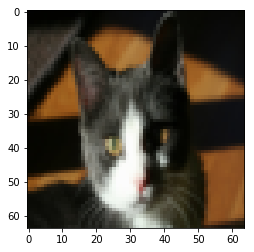

In [62]:
train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()

i=19
plt.imshow(train_set_X_orig[i])
print('y = '+str(train_set_Y_orig[i])+'. It is a '+classes[train_set_Y_orig[i]].decode('utf-8')+' picture')

train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig)
print(train_set_X.shape,train_set_Y.shape,test_set_X.shape,test_set_Y.shape)

In [0]:
def Data_Preprocessing():
  
  train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig)
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Create_Placeholder(shape,output_neurons):
  
  X = tf.placeholder(name='X',dtype=tf.float32,shape=(shape[0],None))
  Y = tf.placeholder(name='Y',dtype=tf.float32,shape=(None,output_neurons))
  
  return X,Y

In [0]:
def Initialize_Parameters(output_neurons,shape):
  
  parameters = {}
  
  W = tf.get_variable(name='W',shape=(output_neurons,shape[0]),initializer=tf.contrib.layers.xavier_initializer())
  b = tf.get_variable(name='b',shape=(output_neurons,1),initializer=tf.zeros_initializer())
  
  parameters['W'] = W
  parameters['b'] = b
  
  return parameters

In [0]:
def compute_cost_sigmoid(A,Y,parameters,regu,lambd):
  
  m_train = tf.cast(tf.shape(Y)[0],dtype=tf.float32)
  cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=A,labels=Y))
  
  if(regu):
    sum = tf.Variable(0.0)
    W = parameters['W']
    sum = tf.add(sum,tf.nn.l2_loss(W))
    sum = tf.divide(tf.multiply(sum,lambd),m_train)
    
    cost = tf.add(cost,sum)
  
  return cost

In [0]:
def compute_cost_softmax(A,Y,parameters,regu,lambd):
  
  m_train = tf.cast(tf.shape(Y)[0],dtype=tf.float32)
  A = tf.transpose(A)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=A,labels=Y))
  
  if(regu):
    sum = tf.Variable(0.0)
    W = parameters['W']
    sum = tf.add(sum,tf.nn.l2_loss(W))
    sum = tf.divide(tf.multiply(sum,lambd),m_train)
    
    cost = tf.add(cost,sum)
  
  return cost

In [0]:
def Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size):
  
  m_train = train_set_X.shape[1]
  perm = list(np.random.permutation(m_train))
  train_set_X = train_set_X[:,perm]
  train_set_Y = train_set_Y[perm,:]
  
  n = int(m_train/mini_batch_size)
  minibatches = []
  
  for i in range(n):
    X = train_set_X[:,i*mini_batch_size:(i+1)*mini_batch_size]
    Y = train_set_Y[i*mini_batch_size:(i+1)*mini_batch_size,:]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  if(m_train % mini_batch_size != 0):
    X = train_set_X[:,n*mini_batch_size:m_train]
    Y = train_set_Y[n*mini_batch_size:m_train,:]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  return minibatches

In [0]:
def Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,output_neurons,regu,lambd,mini_batch_size):
  
  if(output_neurons > 1):
    activation = 'softmax'
    train_set_Y = np.eye(output_neurons)[train_set_Y.T][0]
    test_set_Y = np.eye(output_neurons)[test_set_Y.T][0]
  else:
      activation = 'sigmoid'
  
  X,Y = Create_Placeholder(train_set_X.shape,output_neurons)
  parameters = Initialize_Parameters(output_neurons,train_set_X.shape)
  W = parameters['W']
  b = parameters['b']
  ZNorm = tf.add(tf.matmul(W,X),b)
  #ZNorm = tf.layers.batch_normalization(Z,axis=0,epsilon=0.0001,center=True,scale=True,gamma_initializer=tf.contrib.layers.xavier_initializer(),beta_initializer=tf.zeros_initializer())
  
  if(activation == 'softmax'):
    cost = compute_cost_softmax(ZNorm,Y,parameters,regu,lambd)
  else:
    cost = compute_cost_sigmoid(ZNorm,Y,parameters,regu,lambd)
  
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
  
  init = tf.global_variables_initializer()
  sess = tf.Session()
  sess.run(init)
  total_cost = []
  
  for i in range(epochs):
    minibatches = Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size)
    
    for minibatch in minibatches:
      (minibatch_X,minibatch_Y) = minibatch
      val1,val2 = sess.run([cost,optimizer],feed_dict={X:minibatch_X,Y:minibatch_Y})
      
      if(i%10 == 0):
        total_cost.append(val1)
    
    if(i%10 == 0):
      print('Cost after '+str(i)+'th Iteration : '+str(val1))
    
  plt.plot(total_cost)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title("Learning_Rate : "+str(learning_rate))
  plt.show()  
  
  if(activation == 'sigmoid'):
    A = tf.sigmoid(ZNorm)
    A = tf.ceil(A-0.5)
    Acc = tf.reduce_mean(tf.multiply(A,Y))*100
  
  else:
    A = tf.nn.softmax(ZNorm)
    A = tf.transpose(A)
    A_val = tf.argmax(A,axis=1)
    A_corr = tf.cast(tf.equal(A_val,tf.argmax(Y,axis=1)),'float')
    Acc = tf.reduce_mean(A_corr)*100
    
  print("Training Set Accuracy  :  ",sess.run(Acc,feed_dict={X:train_set_X,Y:train_set_Y})) 
  print("Test Set Accuracy  :  ",sess.run(Acc,feed_dict={X:test_set_X,Y:test_set_Y}))
  
  parameters = sess.run(parameters)
  
  sess.close()
  
  return parameters

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Data_Preprocessing()
  learning_rate = 0.001
  epochs = 500
  output_neurons = 2
  mini_batch_size = 209
  regu = False
  lambd = 0.01
  parameters = Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,output_neurons,regu,lambd,mini_batch_size)
  
  print('')
  for key,value in parameters.items():
    print(key,value)

Cost after 0th Iteration : 1.0442493
Cost after 10th Iteration : 0.3641956
Cost after 20th Iteration : 0.07176317
Cost after 30th Iteration : 0.03349849
Cost after 40th Iteration : 0.016972447
Cost after 50th Iteration : 0.010733889
Cost after 60th Iteration : 0.008355697
Cost after 70th Iteration : 0.00708951
Cost after 80th Iteration : 0.006223542
Cost after 90th Iteration : 0.0056057815
Cost after 100th Iteration : 0.005107827
Cost after 110th Iteration : 0.0046849125
Cost after 120th Iteration : 0.0043182136
Cost after 130th Iteration : 0.0039957487
Cost after 140th Iteration : 0.0037098594
Cost after 150th Iteration : 0.003454809
Cost after 160th Iteration : 0.0032262078
Cost after 170th Iteration : 0.0030204852
Cost after 180th Iteration : 0.0028346484
Cost after 190th Iteration : 0.0026662084
Cost after 200th Iteration : 0.002513042
Cost after 210th Iteration : 0.002373325
Cost after 220th Iteration : 0.002245521
Cost after 230th Iteration : 0.0021282977
Cost after 240th Iterati

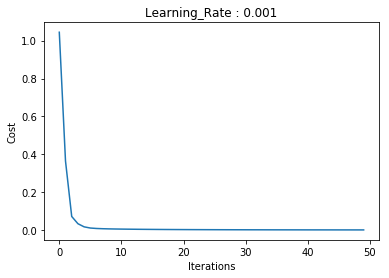

Training Set Accuracy  :   100.0
Test Set Accuracy  :   64.0

W [[ 0.00858008  0.02419569  0.00609205 ...  0.00899736  0.00422484
  -0.02467777]
 [-0.00391195 -0.02887653 -0.01950579 ...  0.01123989 -0.02673627
   0.00665917]]
b [[-0.01129002]
 [ 0.01129004]]


In [152]:
tf.reset_default_graph()
Caller_Function()